<a href="https://colab.research.google.com/github/Vicky-Projects/Machine-learning-projects-1/blob/main/reinforcement_training_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup**

In [1]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install --upgrade numpy
!pip install 'imageio==2.4.1'
!pip install --upgrade imageio
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet



Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:6 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
ffmpeg is already the newest version (7:4.2.7-0u

In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [3]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [4]:
tf.version.VERSION

'2.13.0'

**Parameters**

In [5]:
num_iterations = 2000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 10000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

Environment

In [6]:
env_name = 'CartPole-v1'
env = suite_gym.load(env_name)

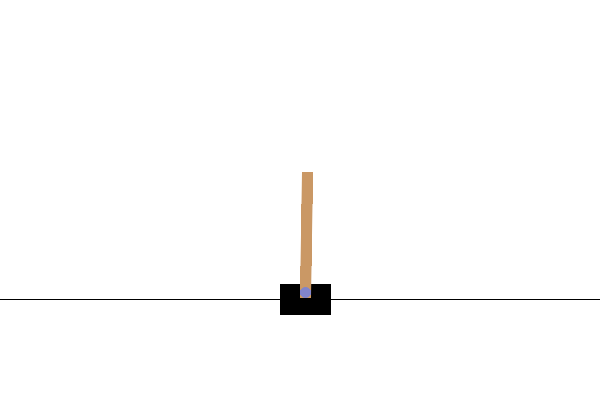

In [7]:
env.reset()
PIL.Image.fromarray(env.render())

In [8]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [9]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [10]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [11]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.03984538, -0.03791911,  0.03222594,  0.04724396], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.039087  ,  0.15672629,  0.03317082, -0.23509975], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [12]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [13]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [14]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

Polices

In [16]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [17]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [18]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v1'))

In [19]:
time_step = example_environment.reset()

In [20]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

Metrics and Evaluation

In [21]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


In [22]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

22.0

Replay Buffer

In [23]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [24]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [25]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

Data Collection

In [26]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([0.32338634, 0.4949962 , 0.00580653, 0.42386442], dtype=float32),
  'reward': array(1., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [27]:
iter(replay_buffer.as_dataset()).next()

(Trajectory(
 {'action': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>,
  'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
  'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'observation': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[-2.1714283e-02,  1.0930212e+00,  1.5220819e-01, -7.4287808e-01],
        [ 1.4614101e-04,  8.9616269e-01,  1.3735063e-01, -4.0642762e-01]],
       dtype=float32)>,
  'policy_info': (),
  'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([5535400987449826963, 5535400987449826963], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.01010101, 0.01010101])>, table_size=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([99, 99])>, prior

In [28]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [29]:
iterator = iter(dataset)
print(iterator)

In [30]:
iterator.next()

(Trajectory(
 {'action': <tf.Tensor: shape=(64, 2), dtype=int64, numpy=
 array([[1, 1],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 1],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 1],
        [1, 0],
        [1, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 1],
        [1, 0],
        [0, 0],
        [1, 0],


Training the agent

In [31]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 74.30530548095703
step = 400: loss = 49.49486541748047
step = 600: loss = 76.71678161621094
step = 800: loss = 129.86337280273438
step = 1000: loss = 242.76756286621094
step = 1000: Average Return = 52.5
step = 1200: loss = 237.41354370117188
step = 1400: loss = 41.103759765625
step = 1600: loss = 36.792449951171875
step = 1800: loss = 337.6756591796875
step = 2000: loss = 68.7262191772461
step = 2000: Average Return = 289.20001220703125


**Visualization**

Plots

(-4.4850006103515625, 250.0)

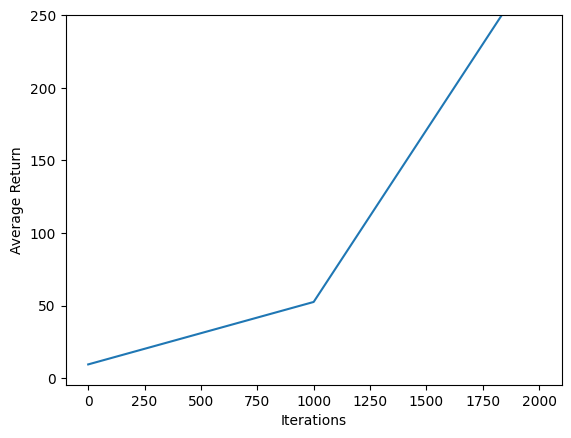

In [32]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

Videos

In [33]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [34]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

In [35]:
create_policy_eval_video(random_policy, "random-agent")